# PUBG Finish Placement Prediction


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


## Workflow process of notebook
1. Import datasets
1. EDA
1. Feature Engineering
1. Modeling
1. Submit

## Importing datasets

In [2]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')

In [3]:
# Display all columns
pd.options.display.max_columns = None

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## Exploratory Data Analysis (EDA)

### Finding Correlation

In [5]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

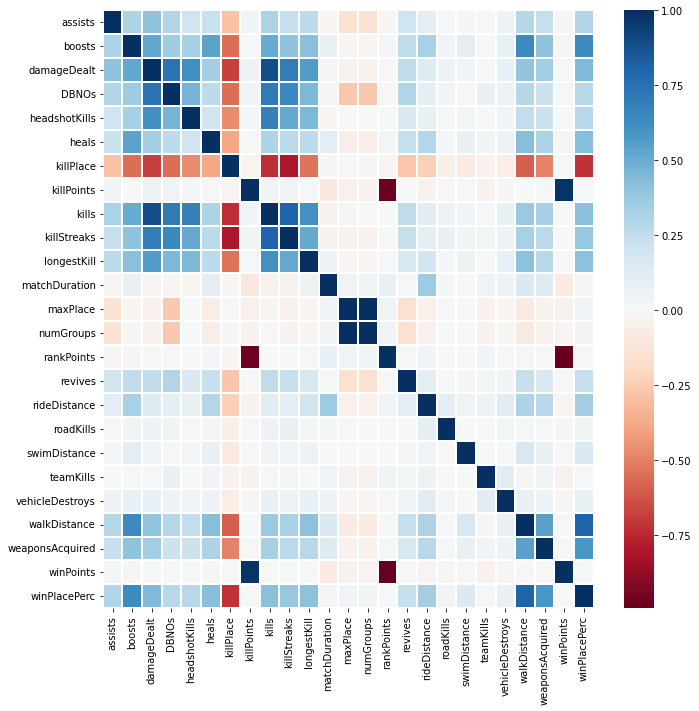

In [6]:
plt.figure(figsize=(11, 11))
sns.heatmap(
    train.corr(),
    linewidths=0.1,
    cmap='RdBu',
)

## Feature Engineering

In [7]:
# Import libraries
import gc
import time
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
# Ideas to experiment

def original(df):
    return df

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby('groupId').size().to_frame('players_in_team')
    df = df.merge(agg, on='groupId')
    return df

def total_distance(df):
    df['total_distance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
    return df

def headshots_over_kills(df):
    df['headshots_over_kills'] = df['headshotKills'] / df['kills']
    df['headshots_over_kills'] = df['headshots_over_kills'].fillna(0)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'] = df['walkDistance_over_heals'].replace(np.inf, 0)
    return df

def walkDistance_over_kills(df):
    df['workDistance_ove_kills'] = df['walkDistance'] / df['kills']
    df['workDistance_ove_kills'] = df['workDistance_ove_kills'].fillna(0)
    df['workDistance_ove_kills'] = df['workDistance_ove_kills'].replace(np.inf, 0)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df
    
def match_mode_classifier(mt):
    if 'solo' in mt:
        return 'solo'
    elif 'duo' in mt:
        return 'duo'
    elif 'squad' in mt:
        return 'squad'
    else:
        return 'others'

In [9]:
# My Idea to experiment
def match_mode(df):
    df['match_mode'] = df['matchType'].map(lambda mt: match_mode_classifier(mt))
    dummies = pd.get_dummies(df['match_mode'])
    df = df.join(dummies)
    df = df.drop('match_mode', axis=1)
    return df

In [10]:
# Function to run experiments
def run_experiments(functions):
    results = []
    for function in functions:
        start = time.time()
        score = run_experiment(function)
        execution_time = time.time() - start
        result = {
            'name': function.__name__,
            'score': score,
            'exection time': f'{round(execution_time, 2)}s'
        }
        print(result)
        results.append(result)
        gc.collect()
    return pd.DataFrame(results, columns=['name', 'score', 'execution time']).sort_values(by='score')

In [11]:
# Function to run a experiment
def run_experiment(function):
    df = train.copy()
    df = function(df)
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
    cols_to_fit = [
        col
        for col in df.columns
        if col not in cols_to_drop
    ]
    
    X = df[cols_to_fit]
    y = df[target].fillna(df[target].mean())
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
    
    model = LGBMRegressor(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_absolute_error(y_pred, y_valid)

In [12]:
# # Run Experiments!
# run_experiments([
#     teamwork,
#     match_mode,
#     original,
#     items,
#     players_in_team,
#     total_distance,
#     headshots_over_kills,
#     killPlace_over_maxPlace,
#     walkDistance_over_heals,
#     walkDistance_over_kills,
# ])

In [13]:
# Ideas to experiment
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

In [14]:
# My Idea to experiment

In [15]:
# # Run Experiments!
# run_experiments([
#     original,
#     min_by_team,
#     max_by_team,
#     sum_by_team,
#     median_by_team,
#     mean_by_team,
#     rank_by_team
# ])

## Permutation Importance

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]

X = train[cols_to_fit]
y = train[target].fillna(train[target].mean())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

model = LGBMRegressor(random_state=0)
model.fit(X_train, y_train)

perm = PermutationImportance(model, random_state=42).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names=list(cols_to_fit))

Weight,Feature
1.3475 ± 0.0029,killPlace
0.3965 ± 0.0007,walkDistance
0.2341 ± 0.0002,kills
0.0512 ± 0.0002,numGroups
0.0271 ± 0.0001,matchDuration
0.0226 ± 0.0000,maxPlace
0.0134 ± 0.0001,killStreaks
0.0061 ± 0.0001,boosts
0.0056 ± 0.0000,rideDistance
0.0028 ± 0.0001,weaponsAcquired


## Promising Features

**We couldn't run all of promissing aggregates because of memory usage error..**

In [17]:
def run_promising_preprocesses(df):
    # Caution! There are dependencies to run.
    df = run_promissing_aggregates(df)
    df = run_promissing_conversions(df)
    df = run_promissing_creations(df)
    return df

def run_promissing_aggregates(df):
    # Common
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    
    # Aggregates
#     agg_min = df.groupby(['matchId','groupId'])[features].min()
#     agg_max = df.groupby(['matchId', 'groupId'])[features].max()
#     agg_sum = df.groupby(['matchId', 'groupId'])[features].sum()
#     agg_median = df.groupby(['matchId', 'groupId'])[features].median()
    agg_mean = df.groupby(['matchId', 'groupId'])[features].mean()
    agg_rank = agg_mean.groupby('matchId')[features].rank(pct=True)
    
    # Merge
#     df = df.merge(agg_min, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])
#     df = df.merge(agg_max, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])
#     df = df.merge(agg_sum, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])
#     df = df.merge(agg_median, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])
#     df = df.merge(agg_mean, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])
    df = df.merge(agg_rank, suffixes=['', '_rank'], how='left', on=['matchId', 'groupId'])
    
    return df

def run_promissing_conversions(df):
    df = match_mode(df) # One-Hot encoding 'matchMode'
    return df

def run_promissing_creations(df):
    df = players_in_team(df) # Add 'players_in_team'
    df = killPlace_over_maxPlace(df) # Add 'killPlace_over_maxPlace'
    df = total_distance(df) # Add 'total_distance'
    df = items(df) # Add 'total_distance'
    return df

In [18]:
# Run Promising Preprocesses
train_preprocessed = run_promising_preprocesses(train.copy())
train_preprocessed

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,assists_rank,boosts_rank,damageDealt_rank,DBNOs_rank,headshotKills_rank,heals_rank,killPlace_rank,killPoints_rank,kills_rank,killStreaks_rank,longestKill_rank,matchDuration_rank,maxPlace_rank,numGroups_rank,rankPoints_rank,revives_rank,rideDistance_rank,roadKills_rank,swimDistance_rank,teamKills_rank,vehicleDestroys_rank,walkDistance_rank,weaponsAcquired_rank,winPoints_rank,duo,others,solo,squad,players_in_team,killPlace_over_maxPlace,total_distance,items
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,0.250000,0.230769,0.500000,0.403846,0.653846,0.192308,0.615385,0.538462,0.634615,0.288462,0.384615,0.519231,0.519231,0.519231,0.519231,0.326923,0.423077,0.519231,0.500000,0.442308,0.519231,0.384615,0.192308,0.192308,0,0,0,1,4,2.142857,244.8000,0
1,7516514fbd1091,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,62,1232,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,48.28,1,1465,0.4444,0.250000,0.230769,0.500000,0.403846,0.653846,0.192308,0.615385,0.538462,0.634615,0.288462,0.384615,0.519231,0.519231,0.519231,0.519231,0.326923,0.423077,0.519231,0.500000,0.442308,0.519231,0.384615,0.192308,0.192308,0,0,0,1,4,2.214286,48.2800,0
2,c56d45be16aa86,4d4b580de459be,a10357fd1a4a91,0,0,318.00,2,1,0,6,1185,4,1,27.66,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,342.80,2,1476,0.4444,0.250000,0.230769,0.500000,0.403846,0.653846,0.192308,0.615385,0.538462,0.634615,0.288462,0.384615,0.519231,0.519231,0.519231,0.519231,0.326923,0.423077,0.519231,0.500000,0.442308,0.519231,0.384615,0.192308,0.192308,0,0,0,1,4,0.214286,342.8000,0
3,100eef17c4d773,4d4b580de459be,a10357fd1a4a91,0,0,90.75,0,0,0,61,1344,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,96.08,1,1498,0.4444,0.250000,0.230769,0.500000,0.403846,0.653846,0.192308,0.615385,0.538462,0.634615,0.288462,0.384615,0.519231,0.519231,0.519231,0.519231,0.326923,0.423077,0.519231,0.500000,0.442308,0.519231,0.384615,0.192308,0.192308,0,0,0,1,4,2.178571,96.0800,0
4,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,0.820000,0.720000,0.680000,0.400000,0.280000,0.880000,0.440000,0.520000,0.620000,0.620000,0.720000,0.520000,0.520000,0.520000,0.600000,0.360000,0.920000,0.520000,0.960000,0.500000,0.500000,0.560000,0.860000,0.520000,0,0,0,1,4,2.192308,1445.0445,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,d05b0c4b2ff311,8248fa2552457b,88c002b589d411,0,0,203.50,0,0,0,32,0,1,1,11.27,1897,solo-fpp,95,92,1489,0,0.0000,0,0.00,0,0,1559.00,5,0,0.5000,0.483696,0.282609,0.782609,0.505435,0.396739,0.309783,0.347826,0.505435,0.652174,0.750000,0.652174,0.505435,0.505435,0.505435,0.114130,0.505435,0.326087,0.483696,0.494565,0.500000,0.500000,0.630435,0.603261,0.505435,0,0,1,0,1,0.336842,1559.0000,0
4446962,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,0,30.10,0,0,0,58,1007,0,0,0.00,1908,solo-fpp,99,97,-1,0,0.0000,0,0.00,0,0,2146.00,6,1502,0.5306,0.469072,0.304124,0.386598,0.505155,0.443299,0.309278,0.587629,0.123711,0.293814,0.293814,0.293814,0.505155,0.505155,0.505155,0.505155,0.505155,0.298969,0.500000,0.500000,0.505155,0.505155,0.773196,0.731959,0.427835,0,0,1,0,1,0.585859,2146.0000,0
4446963,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,0,22.68,0,0,0,89,0,0,0,0.00,1456,solo-fpp,96,95,1787,0,0.0000,0,0.00,0,0,40.25,1,0,0.0842,0.484211,0.300000,0.242105,0.505263,0.415789,0.342105,0.926316,0.505263,0.242105,0.242105,0.242105,0.505

In [19]:
# Evaluate
def evaluate(df):
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    X = df[cols_to_fit]
    y = df[target].fillna(df[target].mean())

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

    model = LGBMRegressor(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_absolute_error(y_pred, y_valid)

evaluate(train_preprocessed)

0.04509086398747909

In [20]:
# Output Memory Usage
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       272|
|            LGBMRegressor|      2008|
|                      Out|       248|
|    PermutationImportance|      1472|
|                        X| 853817632|
|                  X_train| 667044832|
|                  X_valid| 222348432|
|             cols_to_drop|       112|
|              cols_to_fit|       272|
|                  dirname|        95|
|                     eli5|        88|
|                 evaluate|       144|
|                     exit|        64|
|                 filename|        73|
|                filenames|       104|
|                       gc|        88|
|              get_ipython|        72|
|     headshots_over_kills|       144|
|                    items|       144|
|  killPlace_over_maxPlace|       144|
|               match_mode|       144|
|    match_mode_classifier|       144|
|              max_by_team|       144|
|      mean_absolute_erro

# Modeling

In [21]:
# Fitting with promissing data
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in train_preprocessed.columns if col not in cols_to_drop]

X = train_preprocessed[cols_to_fit]
y = train_preprocessed[target].fillna(train_preprocessed[target].mean())

model = LGBMRegressor(random_state=0)
model.fit(X, y)

LGBMRegressor(random_state=0)

In [22]:
# Import Test Data
test = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

In [23]:
# Run Promising Preprocesses in Test
test_preprocessed = run_promising_preprocesses(test.copy())
test_preprocessed

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,assists_rank,boosts_rank,damageDealt_rank,DBNOs_rank,headshotKills_rank,heals_rank,killPlace_rank,killPoints_rank,kills_rank,killStreaks_rank,longestKill_rank,matchDuration_rank,maxPlace_rank,numGroups_rank,rankPoints_rank,revives_rank,rideDistance_rank,roadKills_rank,swimDistance_rank,teamKills_rank,vehicleDestroys_rank,walkDistance_rank,weaponsAcquired_rank,winPoints_rank,duo,others,solo,squad,players_in_team,killPlace_over_maxPlace,total_distance,items
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000,1,0,0.625000,0.178571,0.178571,0.196429,0.321429,0.178571,0.928571,0.517857,0.160714,0.160714,0.160714,0.517857,0.517857,0.517857,0.357143,0.267857,0.428571,0.500000,0.446429,0.464286,0.464286,0.392857,0.178571,0.517857,0,0,0,1,4,2.607143,588.000,0
1,d6267a32c5709c,676b23c24e70d6,45b576ab7daa7f,0,0,0.00,0,0,0,71,0,0,0,0.00,1884,squad-fpp,28,28,1368,0,2694.0,0,0.0,0,0,549.500,0,0,0.625000,0.178571,0.178571,0.196429,0.321429,0.178571,0.928571,0.517857,0.160714,0.160714,0.160714,0.517857,0.517857,0.517857,0.357143,0.267857,0.428571,0.500000,0.446429,0.464286,0.464286,0.392857,0.178571,0.517857,0,0,0,1,4,2.535714,3243.500,0
2,b896f8954a92e2,676b23c24e70d6,45b576ab7daa7f,1,0,74.20,1,0,0,72,0,0,0,0.00,1884,squad-fpp,28,28,1429,0,0.0,0,0.0,0,0,386.300,7,0,0.625000,0.178571,0.178571,0.196429,0.321429,0.178571,0.928571,0.517857,0.160714,0.160714,0.160714,0.517857,0.517857,0.517857,0.357143,0.267857,0.428571,0.500000,0.446429,0.464286,0.464286,0.392857,0.178571,0.517857,0,0,0,1,4,2.571429,386.300,0
3,2f134f2c7be198,676b23c24e70d6,45b576ab7daa7f,0,0,0.00,0,0,0,70,0,0,0,0.00,1884,squad-fpp,28,28,1488,0,0.0,0,0.0,0,0,913.000,2,0,0.625000,0.178571,0.178571,0.196429,0.321429,0.178571,0.928571,0.517857,0.160714,0.160714,0.160714,0.517857,0.517857,0.517857,0.357143,0.267857,0.428571,0.500000,0.446429,0.464286,0.464286,0.392857,0.178571,0.517857,0,0,0,1,4,2.500000,913.000,0
4,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000,6,0,0.840426,0.978723,0.957447,0.978723,0.851064,0.829787,0.042553,0.510638,0.978723,0.957447,1.000000,0.510638,0.510638,0.510638,0.574468,0.989362,0.936170,0.510638,0.489362,0.489362,0.500000,0.787234,0.872340,0.510638,1,0,0,0,2,0.229167,6686.000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934169,dadb017a444602,97572de2a4da68,00eaf1db913030,0,0,100.00,0,0,0,40,0,1,1,4.07,1441,solo-fpp,94,93,1477,0,0.0,0,0.0,0,0,91.190,1,0,0.489247,0.333333,0.655914,0.505376,0.392473,0.381720,0.430108,0.505376,0.682796,0.774194,0.591398,0.505376,0.505376,0.505376,0.032258,0.505376,0.478495,0.505376,0.483871,0.500000,0.505376,0.268817,0.161290,0.505376,0,0,1,0,1,0.425532,91.190,0
1934170,4e876c8d185011,7e3ffcf069160d,d75584b6a89a04,0,0,42.57,0,0,0,66,1479,0,0,0.00,1362,solo-fpp,98,95,-1,0,0.0,0,0.0,0,0,299.600,1,1614,0.478947,0.310526,0.378947,0.505263,0.405263,0.357895,0.673684,0.821053,0.252632,0.252632,0.252632,0.505263,0.505263,0.505263,0.505263,0.505263,0.457895,0.505263,0.473684,0.505263,0.505263,0.473684,0.115789,0.905263,0,0,1,0,1,0.673469,299.600,0
1934171,130020cd922eb9,355623b5def3e6,bdd686c2da1b5a,0,0,11.02,0,0,0,79,0,0,0,0.00,1854,solo-fpp,98,98,1491,0,0.0,0,0.0,0,0,117.000,2,0,0.489796,0.290816,0.387755,0.505102,0.397959,0.321429,0.806122,0.505102,0.290816,0.290816,0.290816,0.505102,0.505102,0.505102,0.127551,0.505102,0.316327,0.500000,0.418367,0.474490,0.489796,0.214286,0.244898,0.505102,0,0,

In [24]:
# Predict
X_test = test_preprocessed[cols_to_fit]

y_pred = model.predict(X_test)
y_pred

array([0.24516899, 0.25282745, 0.25286504, ..., 0.21982486, 0.57968348,
       0.00870887])

# Submit

In [25]:
submission = pd.DataFrame({
    'Id': test_preprocessed['Id'], # Caution!
    'winPlacePerc': y_pred
})
submission.to_csv('submission.csv', index=False)